In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import models
from tensorflow.keras import Sequential, layers, optimizers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

# 2 - Deep Learning

## 2.2 - Classification binaire chat / chien (image)

In [2]:
IMG_DIM = (150, 150)
train_files = glob.glob("training_data/*")
train_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)
train_labels = [fn.split('\\')[1].split('.')[0].strip() for fn in train_files]

validation_files = glob.glob("validation_data/*")
validation_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in validation_files]
validation_imgs = np.array(validation_imgs)
validation_labels = [fn.split('\\')[1].split('.')[0].strip() for fn in validation_files]

print(f"Train dataset shape: {train_imgs.shape} \tValidation dataset shape: {validation_imgs.shape}")

Train dataset shape: (3000, 150, 150, 3) 	Validation dataset shape: (1000, 150, 150, 3)


In [3]:
train_imgs /= 255
validation_imgs /= 255

In [4]:
le = LabelEncoder()
le.fit(["cat", "dog"])

train_labels = le.transform(train_labels)
validation_labels = le.transform(validation_labels)

print(f"Labels from 1495 to 1505: {train_labels[1495:1505]}")

Labels from 1495 to 1505: [0 0 0 0 0 0 0 0 0 0]


### 2.2.1 Un modèle simple

In [5]:
model = Sequential([
    layers.Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=(IMG_DIM + (3,))),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        9280      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 36992)             0

In [6]:
epochs = 15
batch_size = 30
history = model.fit(x=train_imgs, y=train_labels,
                    validation_data=(validation_imgs, validation_labels),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)

Epoch 1/15
100/100 [==============================] - 13s 39ms/step - loss: 0.7260 - accuracy: 0.5453 - val_loss: 0.6619 - val_accuracy: 0.6200
Epoch 2/15
100/100 [==============================] - 4s 36ms/step - loss: 0.6438 - accuracy: 0.6287 - val_loss: 0.6078 - val_accuracy: 0.6800
Epoch 3/15
100/100 [==============================] - 4s 36ms/step - loss: 0.5879 - accuracy: 0.6900 - val_loss: 0.6042 - val_accuracy: 0.6910
Epoch 4/15
100/100 [==============================] - 4s 36ms/step - loss: 0.5390 - accuracy: 0.7210 - val_loss: 0.5739 - val_accuracy: 0.7090
Epoch 5/15
100/100 [==============================] - 4s 36ms/step - loss: 0.5018 - accuracy: 0.7557 - val_loss: 0.5722 - val_accuracy: 0.6990
Epoch 6/15
100/100 [==============================] - 4s 36ms/step - loss: 0.4611 - accuracy: 0.7827 - val_loss: 0.5369 - val_accuracy: 0.7300
Epoch 7/15
100/100 [==============================] - 4s 36ms/step - loss: 0.4138 - accuracy: 0.8123 - val_loss: 0.5838 - val_accuracy: 0.710

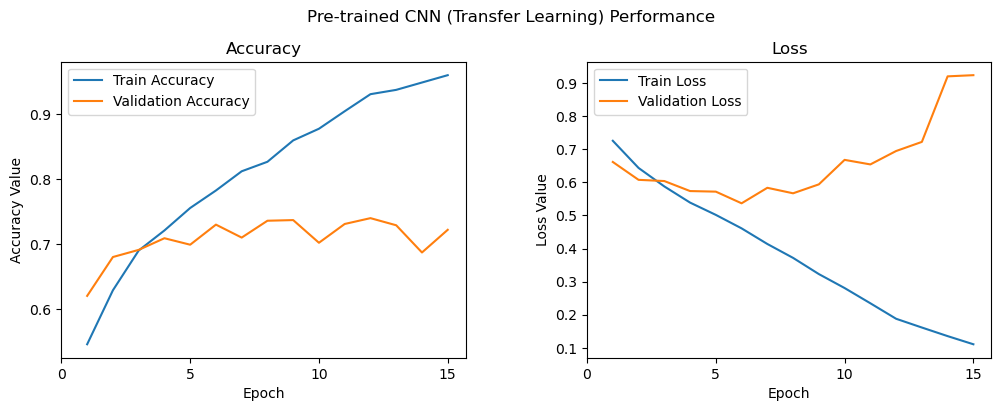

In [7]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Pre-trained CNN (Transfer Learning) Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,epochs +1))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, epochs +1, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epochs +1, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")
plt.show()

### 2.2.2 Modèle simple avec régularisation

In [8]:
model = Sequential([
    layers.Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=(IMG_DIM + (3,))),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(16, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(), metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 72, 72, 64)        9280      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 15, 15, 16)       

In [9]:
history = model.fit(x=train_imgs, y=train_labels,
                    validation_data=(validation_imgs, validation_labels),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)

Epoch 1/15
100/100 [==============================] - 5s 43ms/step - loss: 0.6953 - accuracy: 0.5223 - val_loss: 0.6806 - val_accuracy: 0.5560
Epoch 2/15
100/100 [==============================] - 4s 41ms/step - loss: 0.6721 - accuracy: 0.5863 - val_loss: 0.6489 - val_accuracy: 0.6260
Epoch 3/15
100/100 [==============================] - 4s 41ms/step - loss: 0.6500 - accuracy: 0.6230 - val_loss: 0.6209 - val_accuracy: 0.6330
Epoch 4/15
100/100 [==============================] - 4s 41ms/step - loss: 0.6138 - accuracy: 0.6617 - val_loss: 0.5982 - val_accuracy: 0.6820
Epoch 5/15
100/100 [==============================] - 4s 41ms/step - loss: 0.5751 - accuracy: 0.6917 - val_loss: 0.5700 - val_accuracy: 0.7150
Epoch 6/15
100/100 [==============================] - 4s 41ms/step - loss: 0.5398 - accuracy: 0.7297 - val_loss: 0.7144 - val_accuracy: 0.6660
Epoch 7/15
100/100 [==============================] - 4s 41ms/step - loss: 0.5137 - accuracy: 0.7363 - val_loss: 0.5872 - val_accuracy: 0.7060

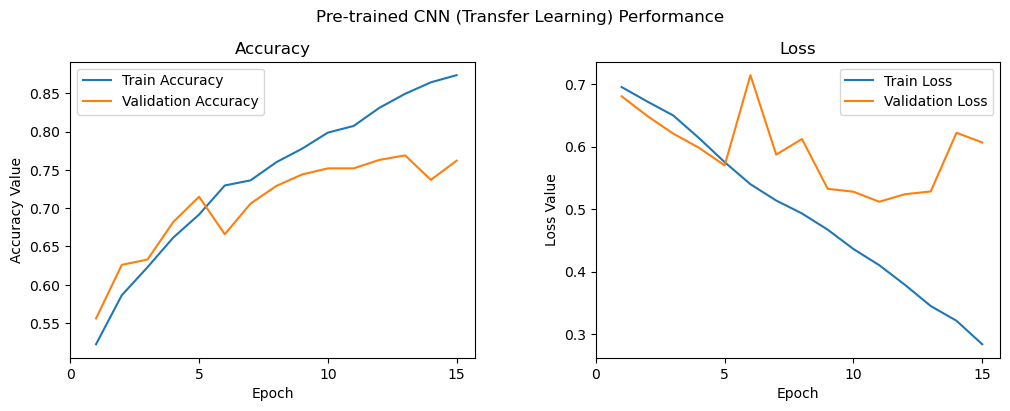

In [10]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Pre-trained CNN (Transfer Learning) Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,epochs +1))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, epochs +1, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epochs +1, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")
plt.show()

### 2.2.3 Modèle simple avec régularisation et augmentation des données

In [11]:
train_datagen = ImageDataGenerator(zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2,
                                   horizontal_flip=True, fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

Labels: [1, 1, 1, 1, 1]


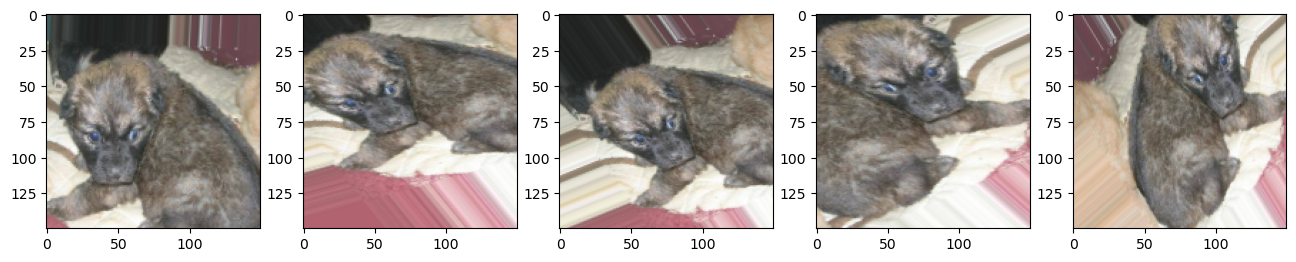

Labels: [1, 1, 1, 1, 1]


In [12]:
img_id = 2595
cat_generator = train_datagen.flow(train_imgs[img_id:img_id + 1], train_labels[img_id:img_id + 1], batch_size=1)
cat = [next(cat_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(16, 6))
print('Labels:', [item[1][0] for item in cat])
l = [ax[i].imshow(cat[i][0][0]) for i in range(0,5)]

plt.show()
img_id = 1991
dog_generator = train_datagen.flow(train_imgs[img_id:img_id+1], train_labels[img_id:img_id + 1], batch_size=1)
dog = [next(dog_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(15, 6))
print('Labels:', [item[1][0] for item in dog])

l = [ax[i].imshow(dog[i][0][0]) for i in range(0,5)]
plt.show()

In [13]:
train_datagen.fit(train_imgs)
train_datagen.fit(validation_imgs)

In [14]:
history = model.fit(x=train_imgs, y=train_labels,
                    validation_data=(validation_imgs, validation_labels),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)

Epoch 1/15
100/100 [==============================] - 4s 43ms/step - loss: 0.2421 - accuracy: 0.9063 - val_loss: 0.6164 - val_accuracy: 0.7690
Epoch 2/15
100/100 [==============================] - 4s 41ms/step - loss: 0.2130 - accuracy: 0.9140 - val_loss: 0.5947 - val_accuracy: 0.7760
Epoch 3/15
100/100 [==============================] - 4s 41ms/step - loss: 0.1996 - accuracy: 0.9163 - val_loss: 0.6977 - val_accuracy: 0.7710
Epoch 4/15
100/100 [==============================] - 4s 40ms/step - loss: 0.1704 - accuracy: 0.9357 - val_loss: 0.7741 - val_accuracy: 0.7710
Epoch 5/15
100/100 [==============================] - 4s 41ms/step - loss: 0.1442 - accuracy: 0.9480 - val_loss: 0.8801 - val_accuracy: 0.7540
Epoch 6/15
100/100 [==============================] - 4s 41ms/step - loss: 0.1196 - accuracy: 0.9537 - val_loss: 1.1081 - val_accuracy: 0.7420
Epoch 7/15
100/100 [==============================] - 4s 41ms/step - loss: 0.1316 - accuracy: 0.9507 - val_loss: 0.8102 - val_accuracy: 0.7760

In [15]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Pre-trained CNN (Transfer Learning) Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,epochs +1))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, epochs +1, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epochs +1, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")
plt.show()

### 2.2.4 Transfert learning

In [16]:
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_DIM + (3,)))

for layer in vgg16.layers:
    layer.trainable = False
    
x = layers.Flatten()(vgg16.output)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs=vgg16.input, outputs=x)

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(), metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [17]:
history = model.fit(x=train_imgs, y=train_labels,
                    validation_data=(validation_imgs, validation_labels),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)

Epoch 1/15
100/100 [==============================] - 24s 184ms/step - loss: 0.6601 - accuracy: 0.7723 - val_loss: 0.3814 - val_accuracy: 0.8190
Epoch 2/15
100/100 [==============================] - 16s 163ms/step - loss: 0.3507 - accuracy: 0.8487 - val_loss: 0.3346 - val_accuracy: 0.8550
Epoch 3/15
100/100 [==============================] - 16s 163ms/step - loss: 0.2839 - accuracy: 0.8747 - val_loss: 0.2950 - val_accuracy: 0.8770
Epoch 4/15
100/100 [==============================] - 16s 164ms/step - loss: 0.2371 - accuracy: 0.9040 - val_loss: 0.3604 - val_accuracy: 0.8430
Epoch 5/15
100/100 [==============================] - 16s 164ms/step - loss: 0.1753 - accuracy: 0.9240 - val_loss: 0.2987 - val_accuracy: 0.8880
Epoch 6/15
100/100 [==============================] - 16s 164ms/step - loss: 0.1425 - accuracy: 0.9423 - val_loss: 0.2844 - val_accuracy: 0.8830
Epoch 7/15
100/100 [==============================] - 16s 164ms/step - loss: 0.1258 - accuracy: 0.9500 - val_loss: 0.2974 - val_ac

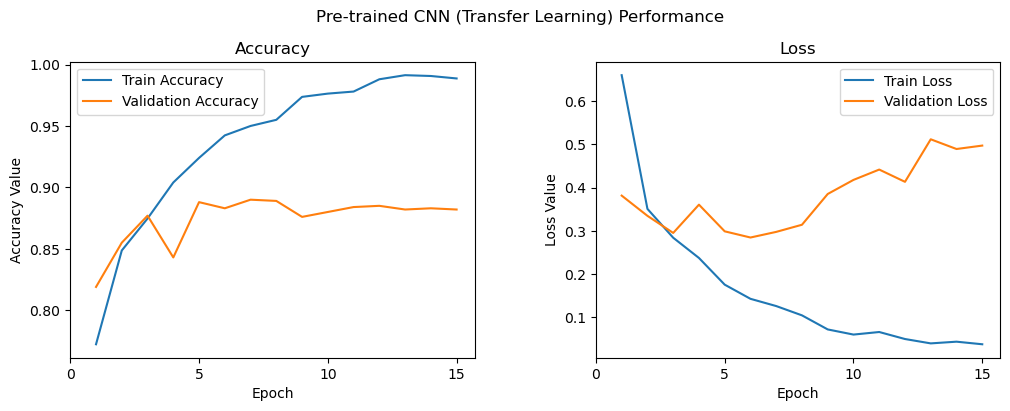

In [18]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Pre-trained CNN (Transfer Learning) Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,epochs +1))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, epochs +1, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epochs +1, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")
plt.show()